# Grover Search Algorithm. This example is to show the quantum search of one item out of a unsorted list of 4 items. The derivation can be found in "The Principles of  Quantum Computation and Information" by G. Benenti et al. 

In [1]:
from qiskit import *
from math import pi
from qiskit.visualization import plot_histogram

In [2]:
IBMQ.load_accounts()

In [3]:
IBMQ.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(ibm-q, open, main)>,
 <IBMQBackend('ibmqx2') from IBMQ(ibm-q, open, main)>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(ibm-q, open, main)>,
 <IBMQBackend('ibmq_vigo') from IBMQ(ibm-q, open, main)>,
 <IBMQBackend('ibmq_ourense') from IBMQ(ibm-q, open, main)>]

The four items are represented by the four basis of two qubits. In this search, the oracle wants to pick the item "10". One ancillary bit is introduced to encode the function evaluation of the oracle. 

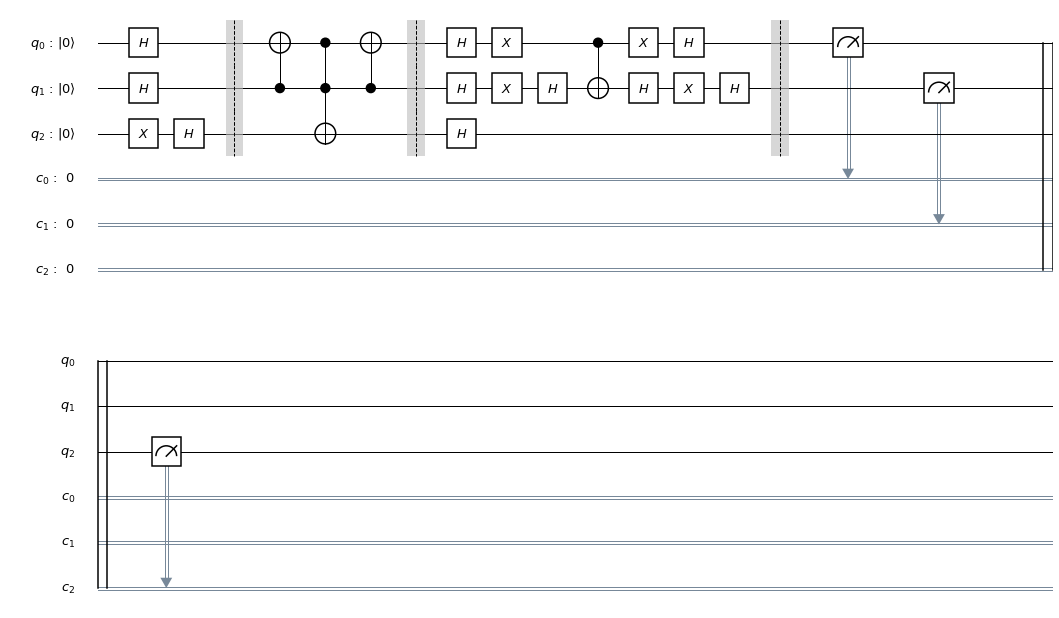

In [19]:
q=QuantumRegister(3,'q')
c=ClassicalRegister(3,'c')
cir=QuantumCircuit(q,c)
cir.x(q[2])
cir.h(q)
# apply oracle
# I want to design an oracle on 3-qubit state
cir.barrier()
cir.cx(q[1],q[0])
cir.ccx(q[0],q[1],q[2])
cir.cx(q[1],q[0])
cir.barrier()
# end of Oracle
#####
cir.h(q[:2])
cir.x(q[:2])
cir.h(q[1])
cir.cx(q[0],q[1])
cir.h(q[1])
cir.x(q[:2])
######
# measurement
cir.h(q)
cir.barrier()
cir.measure(q,c)

cir.draw(output='mpl')

In [16]:
device=Aer.get_backend('statevector_simulator')
result = qiskit.execute(cir, backend=device).result()
result.get_statevector()

array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
        0.+0.j])

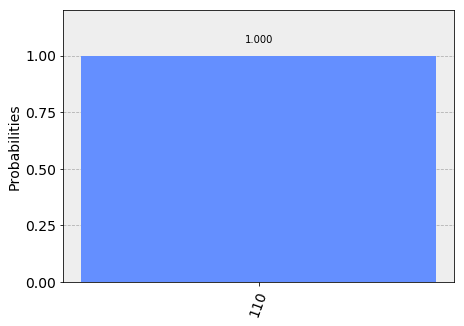

In [20]:
device=Aer.get_backend('qasm_simulator')
result = qiskit.execute(cir, backend=device, shots=1024).result()
plot_histogram(result.get_counts())

The algorithm gives a deterministic result with the selected state "10". Note that the order of the qubit state in the bit string is $q_2q_1q_0.$       
Let's compare the result with the real qubit.    

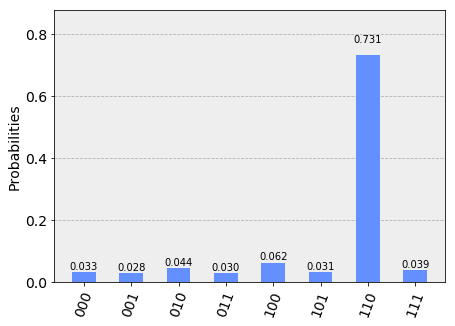

In [22]:
device=IBMQ.get_backend('ibmq_vigo')
result = qiskit.execute(cir, backend=device, shots=1024).result()
plot_histogram(result.get_counts())

However, in the real quantum device, the noise and error leads to the imperfect propabilities in other states. We will discuss how to mitigate the error in the next lecture. 